In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker

import extq

In [2]:
sys.path.insert(1, "../../../python")
sys.path.insert(1, "../../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# displacement charges
dq_trajs = list(np.load(f"{DATA_DIR}/raw_feat/displacement_q_0-178.npy"))
dq_trajs.extend(
    np.load(f"{DATA_DIR}/raw_feat/displacement_q_179-end.npy", allow_pickle=True)
)
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_anton2.npy"))
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

# remove trajectory 180 (missing full data)
cv_trajs = [*cv_trajs[:180], *cv_trajs[181:]]
sb_trajs = [*sb_trajs[:180], *sb_trajs[181:]]
sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)
qp_du = [*qp_du[:180], *qp_du[181:]]
weights = [*weights[:180], *weights[181:]]

In [5]:
print(
    cv_arr.shape,
    sb_arr.shape,
    np.concatenate(qp_du).shape,
    np.concatenate(dq_trajs).shape,
)

(4050115, 2) (4050115, 60) (4050115,) (4050115,)


In [6]:
models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")
sb_models = np.load("/project/dinner/scguo/ci-vsd/data/models_centroids_feat2.npy")

In [7]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

# Average with committor

In [8]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [9]:
def mean_std(trajs, ids):
    arr = np.concatenate(trajs)[ids]
    return np.mean(arr), np.std(arr, ddof=1)


down_avg, down_std = mean_std(dq_trajs, down_ids)
up_avg, up_std = mean_std(dq_trajs, up_ids)
print(down_avg, down_std)
print(up_avg, up_std)
print(up_avg - down_avg, np.sqrt(down_std ** 2 + up_std ** 2))

-4.173267005463239 0.2344045016775164
-3.287910395167272 0.20684185196073684
0.8853566102959669 0.3126164137233235


In [10]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(~(down_ids | up_ids), traj_inds)

In [11]:
from extq.stop import forward_stop

In [12]:
lag = 500
qp_delay = []
w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[:-lag] for dq in dq_trajs]
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

/scratch/local/jobs/3920420/ipykernel_1832986/596547072.py:12: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy
/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


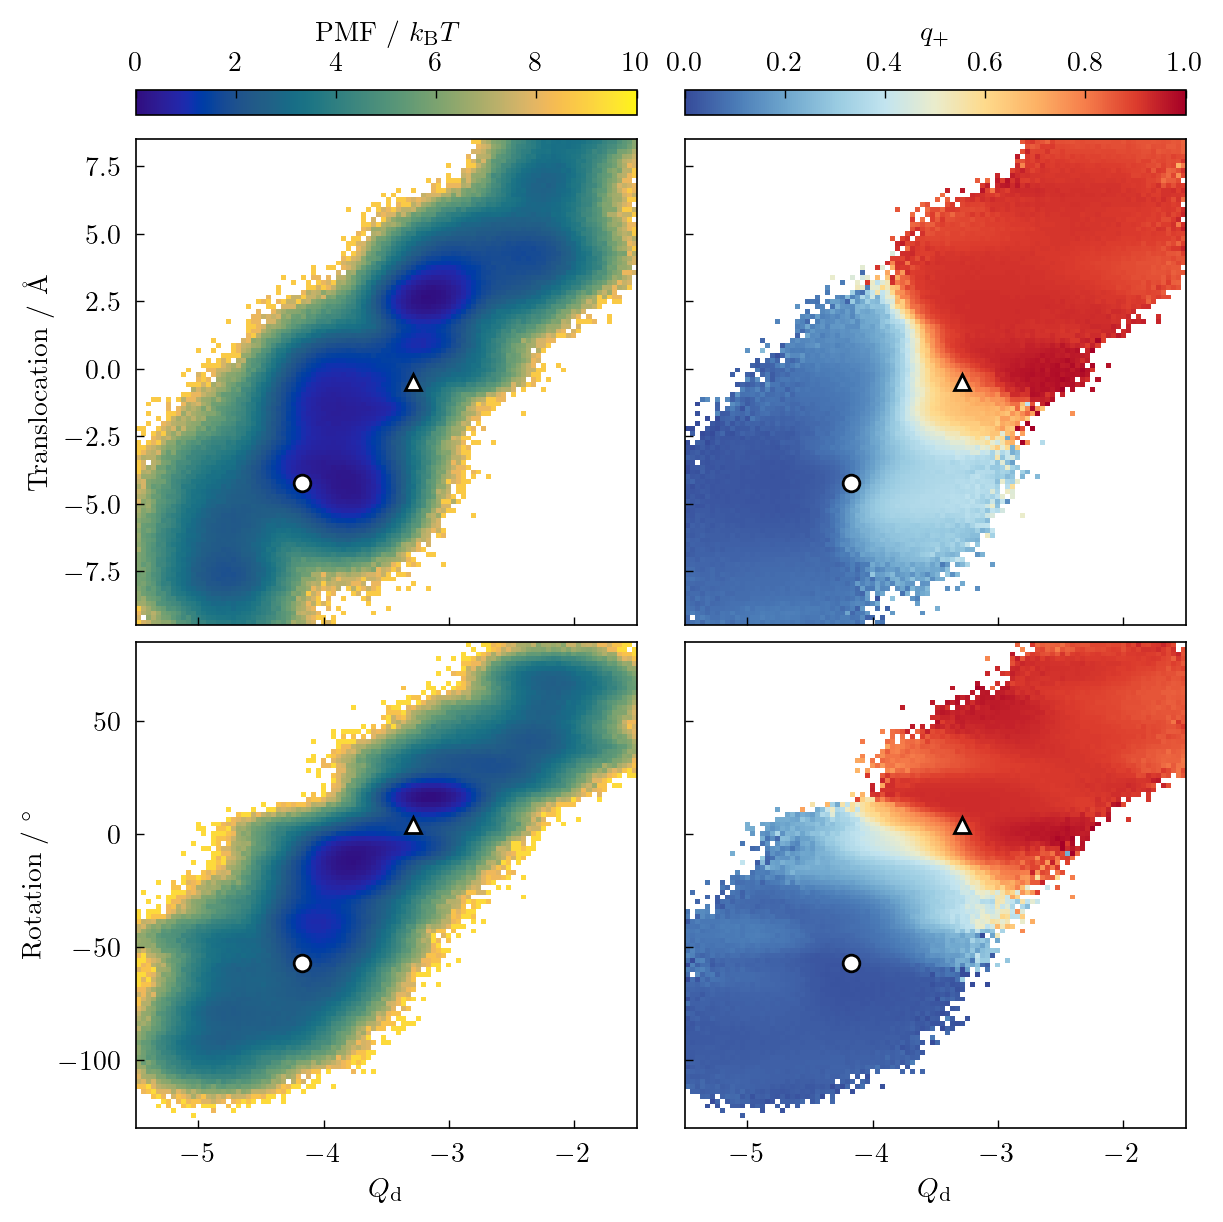

In [13]:
f, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=200, constrained_layout=True)
lo, hi = -5.5, -1.5
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

yedges = [np.linspace(-9.5, 8.5, 101), np.linspace(-130, 85, 101)]
for i, ye in enumerate(yedges):
    cv_delay = [traj[:-lag, i] for traj in cv_trajs]
    cv_nodelay = [traj[:, i] for traj in cv_trajs]
    pmf = extq.projection.density2d(dq_trajs, cv_nodelay, weights, qe, ye)
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf) - min_energy
    pc0 = axes[i, 0].pcolormesh(qe, ye, diff.T, cmap='macaw', vmin=0, vmax=10)
    q_dens = extq.projection.average2d(dq_delay, cv_delay, qp_delay, w_delay, qe, ye)
    pc1 = axes[i, 1].pcolormesh(qe, ye, q_dens.T, cmap='diverging', vmin=0, vmax=1)
    if i == 0:
        plt.colorbar(pc0, ax=axes[0, 0], location="top", label="PMF / $k_{\\rm B}T$")
        plt.colorbar(pc1, ax=axes[0, 1], location="top", label="$q_+$")
    plotting.plot_single_model(axes[0, i], [down_avg, models[1, 0]], label='d', ms=6)
    plotting.plot_single_model(axes[0, i], [up_avg, models[2, 0]], label='u', ms=6)
    plotting.plot_single_model(axes[1, i], [down_avg, models[1, 1]], label='d', ms=6)
    plotting.plot_single_model(axes[1, i], [up_avg, models[2, 1]], label='u', ms=6)
axes[0, 0].set_ylabel("Translocation / $\\textrm{\AA}$")
axes[1, 0].set_ylabel("Rotation / $^\circ$")
axes[1, 0].set_xlabel("$Q_{\\rm d}$")
axes[1, 1].set_xlabel("$Q_{\\rm d}$")
for ax in axes.flat:
    ax.label_outer()

/scratch/local/jobs/3540838/ipykernel_3626171/2000837265.py:14: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


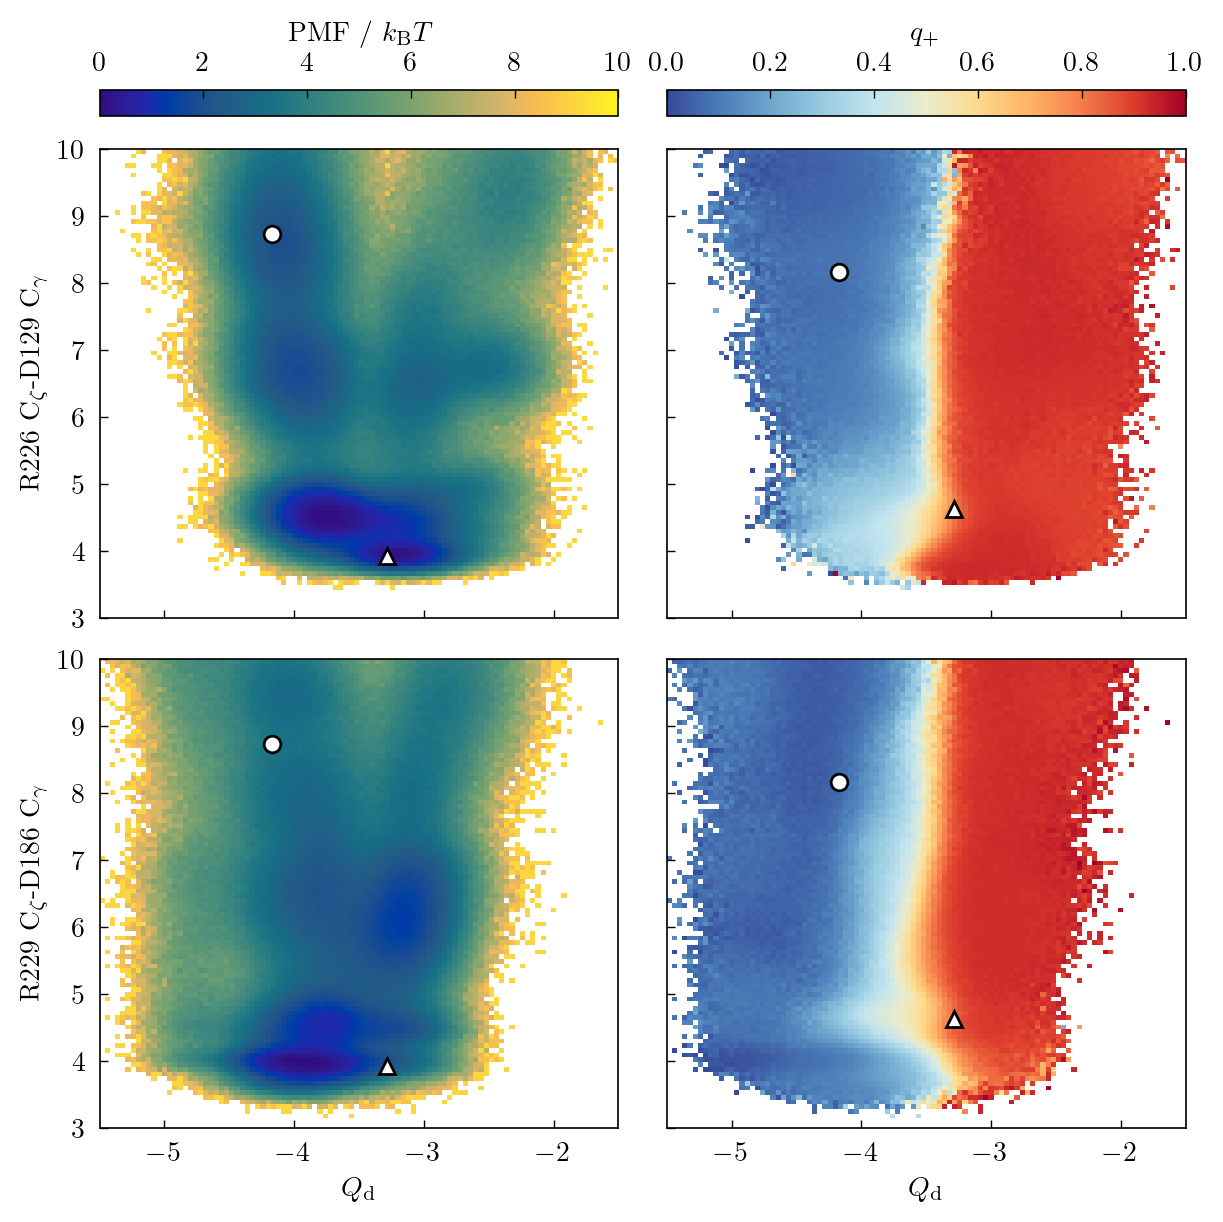

In [36]:
f, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=200, constrained_layout=True)
lo, hi = -5.5, -1.5
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

yedges = [np.linspace(3, 10, 101), np.linspace(3, 10, 101)]
sb_ids = [42, 53]

for i, (ye, sb) in enumerate(zip(yedges, sb_ids)):
    cv_delay = [traj[:-lag, sb] * 10 for traj in sb_trajs]
    cv_nodelay = [traj[:, sb] * 10 for traj in sb_trajs]
    pmf = extq.projection.density2d(dq_trajs, cv_nodelay, weights, qe, ye)
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf) - min_energy
    pc0 = axes[i, 0].pcolormesh(qe, ye, diff.T, cmap='macaw', vmin=0, vmax=10)
    q_dens = extq.projection.average2d(dq_delay, cv_delay, qp_delay, w_delay, qe, ye)
    pc1 = axes[i, 1].pcolormesh(qe, ye, q_dens.T, cmap='diverging', vmin=0, vmax=1)
    if i == 0:
        plt.colorbar(pc0, ax=axes[0, 0], location="top", label="PMF / $k_{\\rm B}T$")
        plt.colorbar(pc1, ax=axes[0, 1], location="top", label="$q_+$")
        
    plotting.plot_single_model(axes[0, i], [down_avg, sb_models[1, sb] * 10], label='d', ms=6)
    plotting.plot_single_model(axes[0, i], [up_avg, sb_models[2, sb] * 10], label='u', ms=6)
    plotting.plot_single_model(axes[1, i], [down_avg, sb_models[1, sb] * 10], label='d', ms=6)
    plotting.plot_single_model(axes[1, i], [up_avg, sb_models[2, sb] * 10], label='u', ms=6)
    
axes[0, 0].set_ylabel(sb_names[sb_ids[0]])
axes[1, 0].set_ylabel(sb_names[sb_ids[1]])
axes[1, 0].set_xlabel("$Q_{\\rm d}$")
axes[1, 1].set_xlabel("$Q_{\\rm d}$")
for ax in axes.flat:
    ax.label_outer()

/scratch/local/jobs/4048918/ipykernel_3134569/872905952.py:24: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


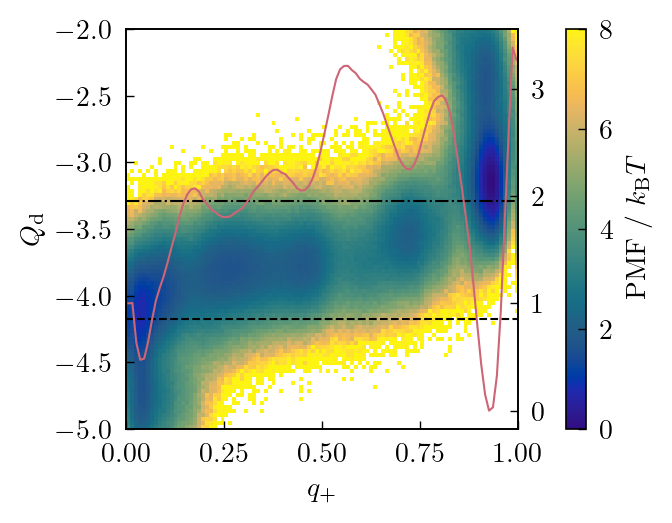

In [15]:
fig = plt.figure(figsize=(3.25, 2.5), dpi=200, constrained_layout=True)
ax = plt.gca()

lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lo, hi = -5., -2
dqe = np.linspace(lo, hi, 101)
dqc = (dqe[1:] + dqe[:-1]) / 2

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

dens = extq.projection.density1d(dq_trajs, weights, dqe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
dq_pmf = -np.log(dens) - min_e

qp_delay = [t[lag:] for t in qp_du]
dq_delay = [t[lag:] for t in dq_trajs]
pmf = extq.projection.density2d(qp_delay, dq_delay, w_delay, qe, dqe)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy
pc0 = ax.pcolormesh(qe, dqe, diff.T, cmap='macaw', vmin=0, vmax=8)
ax_new = ax.twinx()
ax_new.plot(qc, q_pmf)
ax.axhline(down_avg, ls='--', color='black')
ax.axhline(up_avg, ls='-.', color='black')
ax.set_ylabel("$Q_{\\rm d}$")
ax.set_xlabel("$q_+$")

plt.colorbar(pc0, ax=ax, location="right", label="PMF / $k_{\\rm B}T$")

/scratch/local/jobs/3540838/ipykernel_3626171/213878767.py:17: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


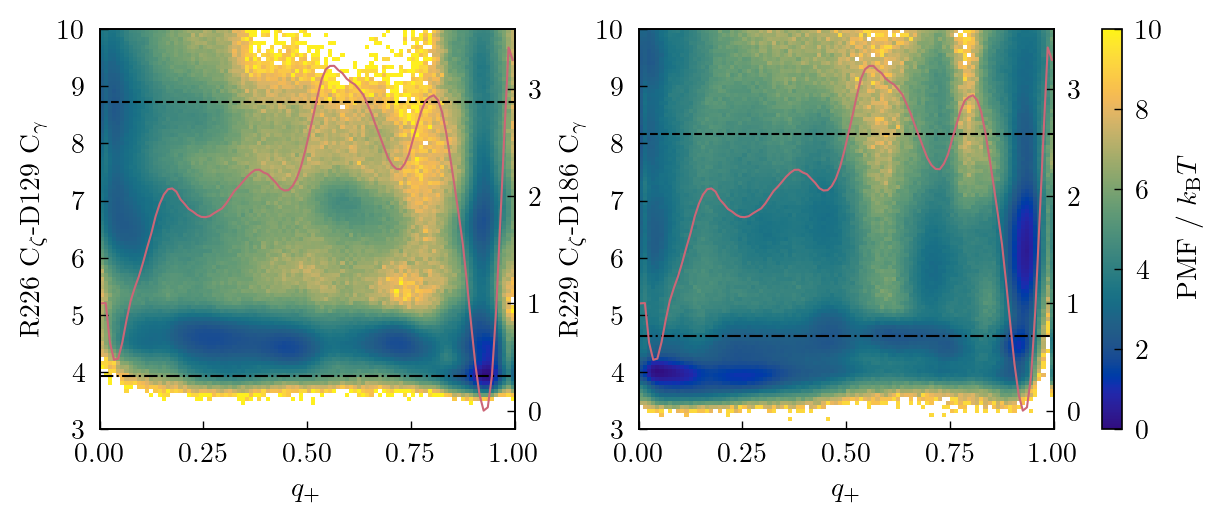

In [30]:
f, axes = plt.subplots(1, 2, figsize=(6, 2.5), dpi=200, constrained_layout=True)
lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

yedges = [np.linspace(3, 10, 101), np.linspace(3, 10, 101)]
sb_ids = [42, 53]

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

for i, (ax, sb, ye) in enumerate(zip(axes, sb_ids, yedges)):
    cv_nodelay = [traj[:, sb] * 10 for traj in sb_trajs]
    pmf = extq.projection.density2d(qp_du, cv_nodelay, weights, qe, ye)
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf) - min_energy
    pc0 = ax.pcolormesh(qe, ye, diff.T, cmap='macaw', vmin=0, vmax=10)
    ax_new = ax.twinx()
    ax_new.plot(qc, q_pmf)
    ax.axhline(sb_models[1, sb] * 10, ls='--', color='black')
    ax.axhline(sb_models[2, sb] * 10, ls='-.', color='black')
    ax.set_ylabel(sb_names[sb])
    ax.set_xlabel("$q_+$")

plt.colorbar(pc0, ax=axes[1], location="right", label="PMF / $k_{\\rm B}T$")

/scratch/local/jobs/3540838/ipykernel_3626171/869609678.py:17: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


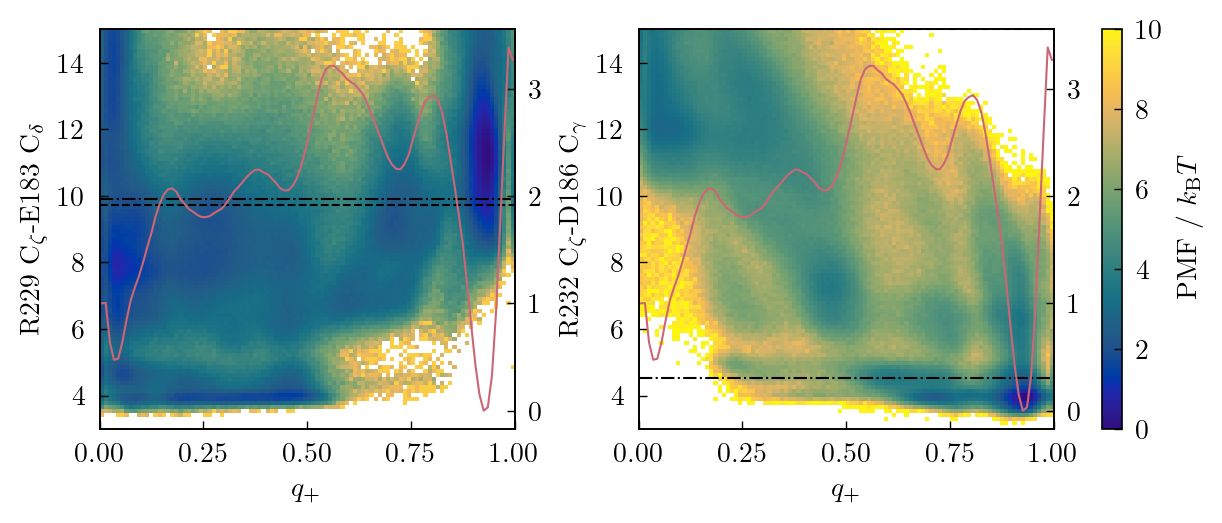

In [32]:
f, axes = plt.subplots(1, 2, figsize=(6, 2.5), dpi=200, constrained_layout=True)
lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

yedges = [np.linspace(3, 15, 101), np.linspace(3, 15, 101)]
sb_ids = [52, 59]

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

for i, (ax, sb, ye) in enumerate(zip(axes, sb_ids, yedges)):
    cv_nodelay = [traj[:, sb] * 10 for traj in sb_trajs]
    pmf = extq.projection.density2d(qp_du, cv_nodelay, weights, qe, ye)
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf) - min_energy
    pc0 = ax.pcolormesh(qe, ye, diff.T, cmap='macaw', vmin=0, vmax=10)
    ax_new = ax.twinx()
    ax_new.plot(qc, q_pmf)
    ax.axhline(sb_models[1, sb] * 10, ls='--', color='black')
    ax.axhline(sb_models[2, sb] * 10, ls='-.', color='black')
    ax.set_ylabel(sb_names[sb])
    ax.set_xlabel("$q_+$")

plt.colorbar(pc0, ax=axes[1], location="right", label="PMF / $k_{\\rm B}T$")

/scratch/local/jobs/3540838/ipykernel_3626171/2278171533.py:16: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


Text(0.5, 0, '$q_+$')

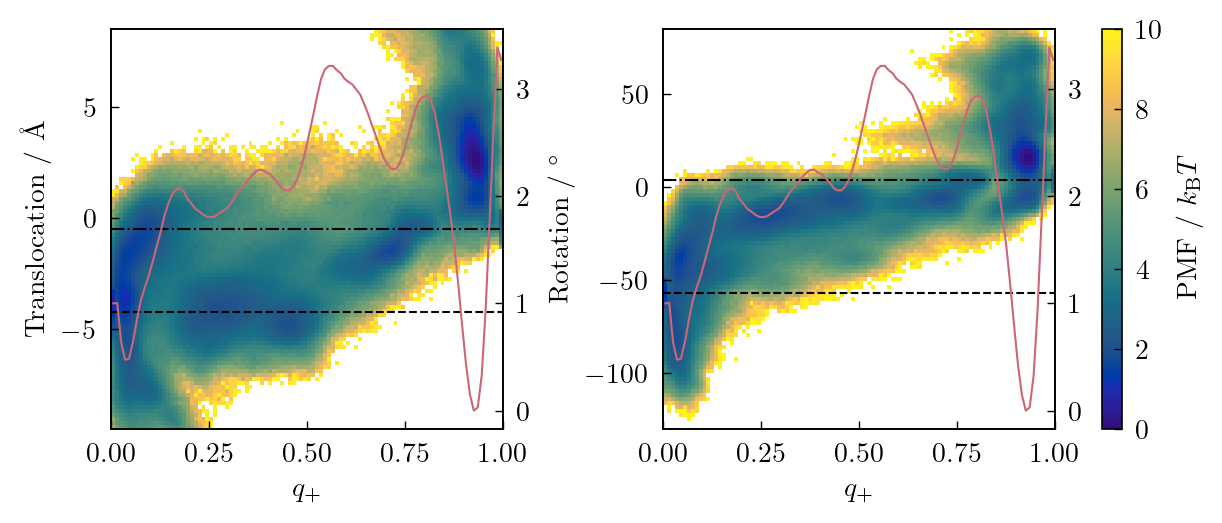

In [27]:
f, axes = plt.subplots(1, 2, figsize=(6, 2.5), dpi=200, constrained_layout=True)
lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

yedges = [np.linspace(), np.linspace(-130, 85, 101)]

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

for i, ye in enumerate(yedges):
    cv_nodelay = [traj[:, i] for traj in cv_trajs]
    pmf = extq.projection.density2d(qp_du, cv_nodelay, weights, qe, ye)
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf) - min_energy
    pc0 = axes[i].pcolormesh(qe, ye, diff.T, cmap='macaw', vmin=0, vmax=10)
    ax_new = axes[i].twinx()
    ax_new.plot(qc, q_pmf)
    axes[i].axhline(models[1, i], ls='--', color='black')
    axes[i].axhline(models[2, i], ls='-.', color='black')

plt.colorbar(pc0, ax=axes[1], location="right", label="PMF / $k_{\\rm B}T$")
axes[0].set_ylabel("Translocation / $\\textrm{\AA}$")
axes[1].set_ylabel("Rotation / $^\circ$")
axes[0].set_xlabel("$q_+$")
axes[1].set_xlabel("$q_+$")